# KorQuAD 1.0 한국어 기계독해 모델 실습

### 실습 환경 구성

In [ ]:
!wget https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/requirements.txt -O requirements.txt
!pip install -r requirements.txt
!pip install tensorflow==2.2.0

--2021-08-05 09:43:12--  https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 610 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]     610  --.-KB/s    in 0s      

2021-08-05 09:43:12 (37.6 MB/s) - ‘requirements.txt’ saved [610/610]

     |████████████████████████████████| 17.3 MB 27 kB/s 
     |████████████████████████████████| 1.4 MB 62.8 MB/s 
     |████████████████████████████████| 43 kB 2.4 MB/s 
     |████████████████████████████████| 769 kB 56.1 MB/s 
     |████████████████████████████████| 1.0 MB 55.7 MB/s 
     |████████████████████████████████| 46.9 MB 44 kB/s 
     |████████████████████████████████| 252 kB 65.6 MB/s 
     |█

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
import re
import json
import string
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import urllib
import wget

MAX_LEN = 384
EPOCHS = 3
VERBOSE = 2
BATCH_SIZE = 16

In [ ]:
DATA_OUT_PATH = 'drive/MyDrive/data_in/KOR'

### 손실값 시각화

- history[string] : 전체 손실값
- history[string_1] : 시작점 손실값
- history[string_2] : 끝점 손실값

In [ ]:
def plot_graphs(history, string, string_1, string_2):
    # loss 
    plt.plot(history.history[string])
    plt.plot(history.history[string_1])
    plt.plot(history.history[string_2])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, string_1, string_2])
    plt.show()

In [ ]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)
np.random.seed(SEED_NUM)

버트 사전 학습 모델을 저장하고 버트 토크나이저 실행

In [ ]:
# Save the slow pretrained tokenizer
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", lowercase=False)
save_path = "bert-base-multilingual-cased/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
slow_tokenizer.save_pretrained(save_path)

# Load the fast tokenizer from saved file
tokenizer = BertWordPieceTokenizer("bert-base-multilingual-cased/vocab.txt", lowercase=False)

### 데이터셋 다운로드

In [ ]:
train_data_url = "https://korquad.github.io/dataset/KorQuAD_v1.0_train.json"
train_path = keras.utils.get_file("train.json", train_data_url)
eval_data_url = "https://korquad.github.io/dataset/KorQuAD_v1.0_dev.json"
eval_path = keras.utils.get_file("eval.json", eval_data_url)

3883008/3881058 [==============================] - 0s 0us/step


### 버트 모델 및 환경 파일 불러오기

In [ ]:
wget.download('https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json', out='./bert-base-multilingual-cased/')

'./bert-base-multilingual-cased//bert-base-multilingual-cased-config.json'

In [ ]:
os.rename('./bert-base-multilingual-cased/bert-base-multilingual-cased-config.json', './bert-base-multilingual-cased/config.json')

In [ ]:
wget.download('https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-tf_model.h5', out='./bert-base-multilingual-cased/')

'./bert-base-multilingual-cased//bert-base-multilingual-cased-tf_model.h5'

In [ ]:
os.rename('./bert-base-multilingual-cased/bert-base-multilingual-cased-tf_model.h5', './bert-base-multilingual-cased/tf_model.h5')

### SquadExample Class

In [ ]:
class SquadExample:
    def __init__(self, question, context, start_char_idx, answer_text):
        self.question = question # 질문
        self.context = context # 질문에 답이 존재하는 본문
        self.start_char_idx = start_char_idx # 본문에서의 시작 위치
        self.answer_text = answer_text # 정
        self.skip = False # 데이터를 사용할지 말지 결정하는 변수

    def preprocess(self):
        context = self.context
        question = self.question
        answer_text = self.answer_text
        start_char_idx = self.start_char_idx

        # Clean context, answer and question
        context = " ".join(str(context).split())
        question = " ".join(str(question).split())
        answer = " ".join(str(answer_text).split())

        # Find end character index of answer in context
        end_char_idx = start_char_idx + len(answer)
        if end_char_idx >= len(context): # end_char_idx가 context 길이를 벗어나면
            self.skip = True # 답이 context 범위 안에 존재하지 않음을 의미
            return

        # Mark the character indexes in context that are in answer
        # context 길이만큼 is_char_in_ans의 값을 모두 0으로 만든다
        is_char_in_ans = [0] * len(context)

        # 답이 존재하는 부분의 인덱스에 1 저장
        for idx in range(start_char_idx, end_char_idx):
            is_char_in_ans[idx] = 1

        # Tokenize context
        tokenized_context = tokenizer.encode(context)

        # Find tokens that were created from answer characters
        ans_token_idx = []
        for idx, (start, end) in enumerate(tokenized_context.offsets):
            if sum(is_char_in_ans[start:end]) > 0:
                ans_token_idx.append(idx)

        # 답이 존재하지 않는 경
        if len(ans_token_idx) == 0: 
            self.skip = True
            return

        # Find start and end token index for tokens from answer
        start_token_idx = ans_token_idx[0]
        end_token_idx = ans_token_idx[-1]

        # Tokenize question
        tokenized_question = tokenizer.encode(question)

        # Create inputs
        input_ids = tokenized_context.ids + tokenized_question.ids[1:]
        
        token_type_ids = [0] * len(tokenized_context.ids) + [1] * len(
            tokenized_question.ids[1:]
        )
        attention_mask = [1] * len(input_ids)

        # Pad and create attention masks.
        # Skip if truncation is needed
        padding_length = MAX_LEN - len(input_ids)
        if padding_length > 0:  # pad
            input_ids = input_ids + ([0] * padding_length)
            attention_mask = attention_mask + ([0] * padding_length)
            token_type_ids = token_type_ids + ([0] * padding_length)
        
        # 예외 처리
        elif padding_length < 0:  # skip
            self.skip = True
            return

        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_mask = attention_mask
        self.start_token_idx = start_token_idx
        self.end_token_idx = end_token_idx
        self.context_token_to_char = tokenized_context.offsets

# json 데이터 구조에서 모델 입력에 필요한 질문, 본문, 정답을 가져오는 함수
def create_squad_examples(raw_data):
    squad_examples = []
    for item in raw_data["data"]:
        for para in item["paragraphs"]:
            context = para["context"] # 본문
            for qa in para["qas"]:
                question = qa["question"] # 질문
                answer_text = qa["answers"][0]["text"] # 정답
                start_char_idx = qa["answers"][0]["answer_start"] # 본문에서 정답의 위치 포지
                squad_eg = SquadExample(
                    question, context, start_char_idx, answer_text
                )
                squad_eg.preprocess()
                squad_examples.append(squad_eg)
    return squad_examples


def create_inputs_targets(squad_examples):

    # dataset_dict 딕셔너리를 만들고 squad_examples의 각 인스턴스 호출해서 item에 넣는다
    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
        "start_token_idx": [],
        "end_token_idx": [],
    }
    for item in squad_examples:
        if item.skip == False:
            for key in dataset_dict:
                dataset_dict[key].append(getattr(item, key)) # item 내의 객체 속성값 가져오
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
    ]
    y = [dataset_dict["start_token_idx"], dataset_dict["end_token_idx"]]
    return x, y


In [ ]:
with open(train_path) as f:
    raw_train_data = json.load(f)

with open(eval_path) as f:
    raw_eval_data = json.load(f)


train_squad_examples = create_squad_examples(raw_train_data)
x_train, y_train = create_inputs_targets(train_squad_examples)
print(f"{len(train_squad_examples)} training points created.")

eval_squad_examples = create_squad_examples(raw_eval_data)
x_eval, y_eval = create_inputs_targets(eval_squad_examples)
print(f"{len(eval_squad_examples)} evaluation points created.")

60407 training points created.
5774 evaluation points created.


# KorQuAD 1.0 학습 및 테스트

In [ ]:
class TFBERTQuestionAnswering(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBERTQuestionAnswering, self).__init__()
        
        self.encoder = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.start_logit = tf.keras.layers.Dense(num_class, name="start_logit", use_bias=False)
        self.end_logit = tf.keras.layers.Dense(num_class, name="end_logit", use_bias=False)
        
        # Flatten 클래스는 다타원을 1차원으로 변환
        self.flatten = tf.keras.layers.Flatten() 
        self.softmax = tf.keras.layers.Activation(tf.keras.activations.softmax)
        
    def call(self, inputs):
        input_ids, token_type_ids, attention_mask = inputs
        embedding = self.encoder(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
        start_logits = self.start_logit(embedding)
        start_logits = self.flatten(start_logits)
        
        end_logits = self.end_logit(embedding)
        end_logits = self.flatten(end_logits)
        
        start_probs = self.softmax(start_logits)
        end_probs = self.softmax(end_logits)
    
        return start_probs, end_probs

### 한국어 기계독해 모델 생성

최적화 함수와 손실 함수를 선언한다.

아담 옵티마이저를 사용하고 learning-rate 인자로 5e-5를 적용한다.

SparseCategoricalCrossentropy를 통해 손실값을 구한다.

In [ ]:
korquad_model = TFBERTQuestionAnswering(model_name='./bert-base-multilingual-cased/',dir_path='bert_ckpt', num_class=1)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)

Some weights of the model checkpoint at ./bert-base-multilingual-cased/ were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at ./bert-base-multilingual-cased/.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


### 후처리 함수 normarlized_answer

In [ ]:
def normalized_answer(s):    
    def remove_(text):
        ''' 불필요한 기호 제거 '''
        text = re.sub("'", " ", text)
        text = re.sub('"', " ", text)
        text = re.sub('《', " ", text)
        text = re.sub('》', " ", text)
        text = re.sub('<', " ", text)
        text = re.sub('>', " ", text) 
        text = re.sub('〈', " ", text)
        text = re.sub('〉', " ", text)   
        text = re.sub("\(", " ", text)
        text = re.sub("\)", " ", text)
        text = re.sub("‘", " ", text)
        text = re.sub("’", " ", text)      
        return text

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_punc(lower(remove_(s))))

### 정확 매칭 구현

In [ ]:
class ExactMatch(keras.callbacks.Callback):
    def __init__(self, x_eval, y_eval):
        self.x_eval = x_eval # 본문과 질문이 결합된 데이터
        self.y_eval = y_eval # 정답을 가지고 있는 데이터

    # 예측한 값과 정답값을 비교하는 함수
    def on_epoch_end(self, epoch, logs=None):

        # self.model.predict 함수에 self.x_eval값을 받아 예측된 시작점과 끝점을 받는다
        pred_start, pred_end = self.model.predict(self.x_eval)
        count = 0

        # 본문에 정답이 존재하는 값들만 모아서 squad_eg에 저장
        eval_examples_no_skip = [_ for _ in eval_squad_examples if _.skip == False]
        for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
            squad_eg = eval_examples_no_skip[idx]
            offsets = squad_eg.context_token_to_char # 정답이 시작하는 본문의 위치정보
            
            # np.argmax를 통해 시작과 끝의 확률값이 가장 높은값을 가져오기
            start = np.argmax(start)
            end = np.argmax(end)

            if start >= len(offsets):
                continue
            pred_char_start = offsets[start][0]
            
            if end < len(offsets):
                pred_char_end = offsets[end][1]
                pred_ans = squad_eg.context[pred_char_start:pred_char_end]
            else:
                pred_ans = squad_eg.context[pred_char_start:]

            normalized_pred_ans = normalized_answer(pred_ans)
            normalized_true_ans = normalized_answer(squad_eg.answer_text)
            
            # 예측값과 정답값이 정확하게 일치하면 count +1
            if normalized_pred_ans in normalized_true_ans:
                count += 1
        acc = count / len(self.y_eval[0]) # 백분율로 표
        print(f"\nepoch={epoch+1}, exact match score={acc:.2f}")

평가 방법 함수를 생성하고 최적화 함수와 손실 함수를 등록한다.

In [ ]:
exact_match_callback = ExactMatch(x_eval, y_eval)

In [ ]:
korquad_model.compile(optimizer=optimizer, loss=[loss, loss])

In [ ]:
model_name = "tf2_bert_korquad"

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, verbose=1, save_best_only=True, save_weights_only=True)

drive/MyDrive/data_in/KOR/tf2_bert_korquad -- Folder create complete 



### 한국어 기계독해 학습

In [ ]:
history = korquad_model.fit(
    x_train,
    y_train,
    epochs=EPOCHS,  # For demonstration, 3 epochs are recommended
    verbose=VERBOSE,
    batch_size=BATCH_SIZE,
    callbacks=[exact_match_callback, cp_callback]
)

Epoch 1/3

epoch=1, exact match score=0.72
2941/2941 - 4657s - loss: 1.6183 - output_1_loss: 0.7433 - output_2_loss: 0.8749
Epoch 2/3

epoch=2, exact match score=0.73
2941/2941 - 4650s - loss: 1.0443 - output_1_loss: 0.4728 - output_2_loss: 0.5715
Epoch 3/3

epoch=3, exact match score=0.74
2941/2941 - 4646s - loss: 0.8177 - output_1_loss: 0.3648 - output_2_loss: 0.4529


In [ ]:
print(history.history)

{'loss': [1.6182780265808105, 1.0442637205123901, 0.8177440762519836], 'output_1_loss': [0.7433304786682129, 0.4727752208709717, 0.3648432195186615], 'output_2_loss': [0.8749469518661499, 0.5714890956878662, 0.45290008187294006]}


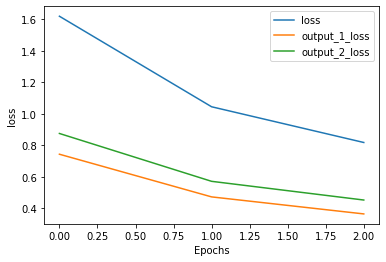

In [ ]:
plot_graphs(history, 'loss', 'output_1_loss', 'output_2_loss')

각 손실이 에폭이 증가함에 따라 감소하며, 그에 따라 전체 손실도 감소한다.

학습이 올바른 방향으로 진행됨을 알 수 있고 Exact Matching으로 73%의 성능을 보여준다.